In [2]:
%%capture

%load_ext autoreload
%autoreload 2
%matplotlib inline
%load_ext tfl_training_anomaly_detection

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload
The tfl_training_anomaly_detection extension is already loaded. To reload it, use:
  %reload_ext tfl_training_anomaly_detection


In [77]:
%presentation_style

In [78]:
%%capture

%set_random_seed 12

In [79]:
%load_latex_macros


$\renewcommand{\vect}[1]{{\mathbf{\boldsymbol{#1}} }}$
$\renewcommand{\amax}{{\text{argmax}}}$
$\renewcommand{\P}{{\mathbb{P}}}$
$\renewcommand{\E}{{\mathbb{E}}}$
$\renewcommand{\R}{{\mathbb{R}}}$
$\renewcommand{\Z}{{\mathbb{Z}}}$
$\renewcommand{\N}{{\mathbb{N}}}$
$\renewcommand{\C}{{\mathbb{C}}}$
$\renewcommand{\abs}[1]{{ \left| #1 \right| }}$
$\renewcommand{\simpl}[1]{{\Delta^{#1} }}$



# Introduction to Anomaly Detection
<img src="./_static/images/aai-institute-cover.png" alt="Snow" style="width:100%;">

In [80]:
import numpy as np


import matplotlib
from matplotlib import pyplot as plt
from matplotlib.patches import Ellipse

from tfl_training_anomaly_detection.exercise_tools import evaluate, visualize_mahalanobis

from ipywidgets import interact

from sklearn.metrics import f1_score, precision_score, recall_score

%matplotlib inline
matplotlib.rcParams['figure.figsize'] = (5, 5)


## Exercise
Try the outlier scores for yourself in a simple synthetic scenario. We have prepared the `evaluate` function for you. Try to find the optimal threshold for the dataset.

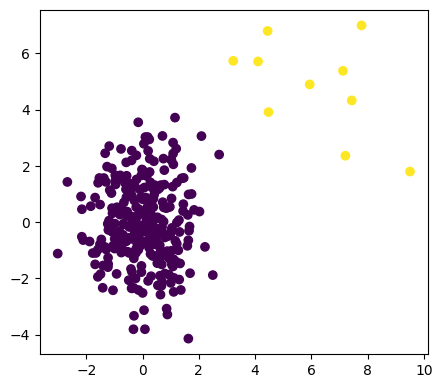

In [84]:
nominal = np.random.normal(0, [1, 1.5], size=(300, 2))
anomaly = np.random.normal(5, 2, size=(10, 2))

data = np.concatenate([nominal, anomaly], axis=0)
y = np.zeros(310)  # 310 Punkte, Default-Farbe setzen
y[-10:] = 1        # letzten 10 Punkte haben andere Farbe

plt.scatter(data[:, 0], data[:,1], c=y)   # 0te Spalte = x, 1te Spalte = x, c = color
plt.gca().set_aspect('equal')
plt.show()

In [ ]:
nominal

**Fit a Gaussian**

In [20]:
mu = data.mean(axis=0)        # mean für x und y Werte der kombinierten Punkte
Sigma_diag = data.std(axis=0) # assumes independent components, std ermitteln, axis=0 über die Zeilen/vertikal
print('Mean: {}\nStd: {}'.format(mu, Sigma_diag))  # für x und y den Mittelwert + Std-Abweichung ausgeben

Mean: [0.18722867 0.11183475]
Std: [1.45443314 1.85978424]


## Question
How did the contamination influence the parameter estimation?

--> answer:
The mean value of x and y shifted from 0 to a slightly positive value.
The standard deviation of x and y also increased from 1/1.5 to 1.45/1.86

**Compute scores and evaluate**  

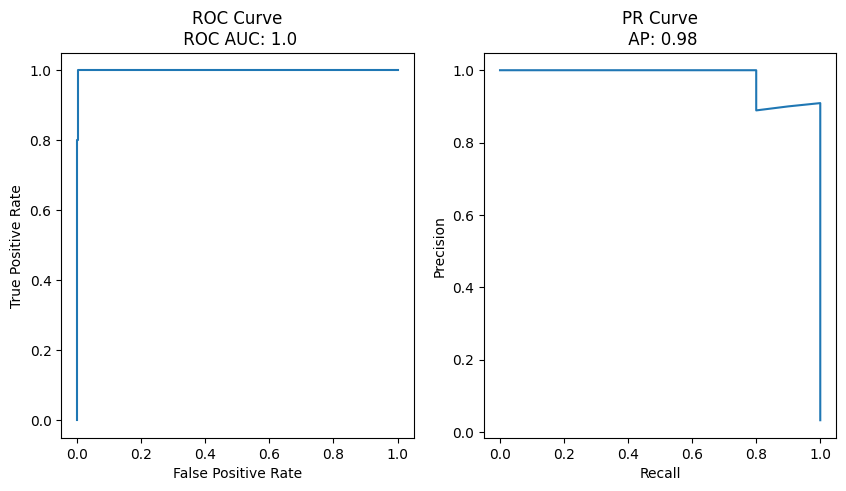

In [38]:
# Mahalanobis distance from the mean of N(mu, Sigma)
# Sigma is actually a matrix with zeros in the main diagonal because the distributions are independent
# The covariance matrix is [[0 1.45][0.86 0]]. The inverse is just the reciprocal of the single elements. 
scores = np.sqrt(((data - mu) * (1/Sigma_diag) * (data - mu)).sum(axis=1)) 
# the sklearn method roc_curve iterates by itself through different thresholds to create a ROC curve
curves = evaluate(y, scores)

In [ ]:
# scores


**Choose a threshold**

In [42]:
def visualize_mahalanotis(data, y, scores, mu, sigma_diag, thr):
    _, axes = plt.subplots(figsize=(6, 6))

    # Visualize Data
    scatter_gt = axes.scatter(data[:, 0], data[:,1], c=y) # draw points by x, y coordinates and color array
    plt.scatter(mu[0], mu[1], color='red')                # draw mean values of x, y as red dot
    axes.set_title('Ground Truth')
    handles, _ = scatter_gt.legend_elements()
    axes.legend(handles, ['Nominal', 'Anomaly'])
    axes.set_aspect('equal')
    # Draw descicion contour (matplotlib.patches module)
    # as x-values and y-values are scaled by its std. deviation, the threshold forms an ellipse
    # sqrt( 1/std1*(x-u1) + 1/std2*(y-u2)) is the distance formula
    descion_border = Ellipse(
        mu,                                  # mean value point (x, y)
        width=2*np.sqrt(sigma_diag[0])*thr,  # std. deviation in x * Threshold
        height=2*np.sqrt(sigma_diag[1])*thr, # std. deviation in y * Threshold
        color='red',
        fill=False
    )
    axes.add_patch(descion_border)
    
    # Evaluate threshold
    y_pred = scores >  thr     # boolean array indicating the guesses

    precision = precision_score(y, y_pred)   # from sklearn.metrics, color-vector compared to boolean array
    recall = recall_score(y, y_pred)         # from sklearn.metrics
    f1 = f1_score(y, y_pred)
    
    axes.set_title("Precision: {}\nRecall: {}\nF1: {}".format(precision, recall, f1))
    
    plt.tight_layout()   # auto adjust size to everything fits into the plot
    plt.show()


In [54]:
thr = None

@interact(threshold=(0., 6.))
def set_threshold(threshold):
    global thr
    thr = threshold
    plt.show()

interactive(children=(FloatSlider(value=3.0, description='threshold', max=6.0), Output()), _dom_classes=('widg…

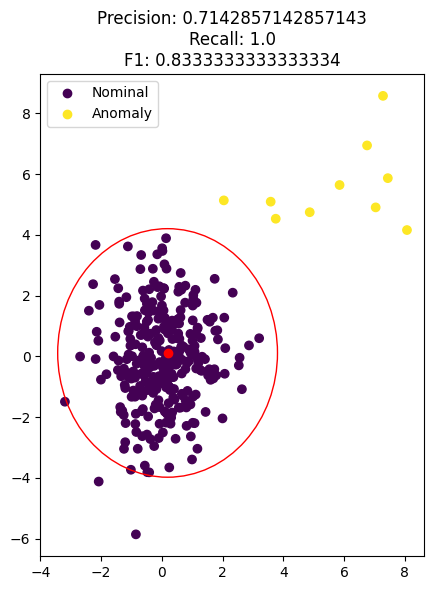

In [57]:
visualize_mahalanobis(data, y, scores, mu, Sigma_diag, thr)

## Task: Find optimal threshold and evaluate on test set.
Choose good threshold. You may write additional code to determine the threshold.

In [142]:
thr_opt = 3.4 # 

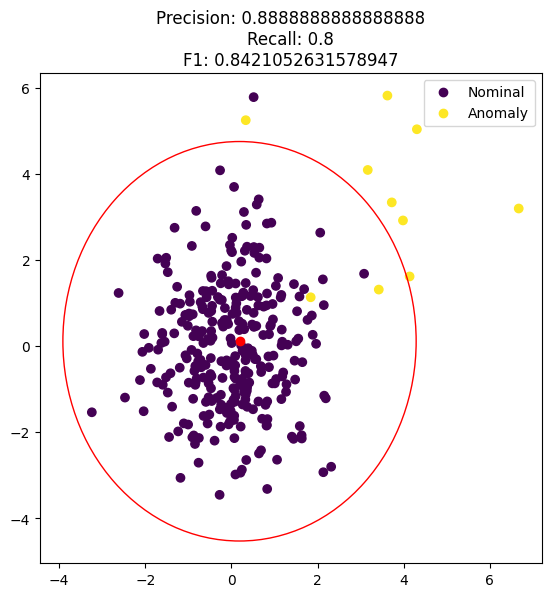

In [ ]:
# fix seed to optimize for a certain list of data points
np.random.seed(42)      
# create new dataset with anomalies closer to the nominal data
data_test = np.concatenate([np.random.normal(0, [1, 1.5], size=(300, 2)), np.random.normal(3, 1.5, size=(10, 2))])

# color vector for first points (nominal) and last 10 points (anomalies)
y_test = np.zeros(data_test.shape[0])
y_test[-10:] = 1

# mahalanotis distance
scores_test = np.sqrt(((data_test - mu) * (1/Sigma_diag) * (data_test - mu)).sum(axis=1)) 

visualize_mahalanotis(data_test, y_test, scores_test, mu, Sigma_diag, thr_opt)

<img src="_static/images/aai-institute-cover.png" alt="Snow" style="width:100%;">

In [141]:

max_score = 0
best_thr = 0

for thr in [x / 10.0 for x in range(0, 50)]:
    mu_th = data_test.mean(axis=0)             # mean for x and y values of the combined data
    Sigma_diag_th = data_test.std(axis=0)      # same with variance
    # calculate mahalanotis distance / suprise
    scores_th = np.sqrt(((data_test - mu_th) * (1/Sigma_diag_th) * (data_test - mu_th)).sum(axis=1)) 
    y_pred_th = scores_th >  thr               # boolean vector with guesses
    precision = precision_score(y, y_pred_th)  # get metrics
    recall = recall_score(y, y_pred_th)        # get metrics 
    if (precision*recall > max_score):         # new high-score?
        max_score = precision*recall
        best_thr = thr
print(best_thr)

3.4


In [137]:
#mu_test = data_test.mean(axis=0)
#Sigma_diag_test = data_test.std(axis=0)
#scores_test = np.sqrt(((data_test - mu) * (1/Sigma_diag) * (data_test - mu)).sum(axis=1)) 
#scores_test